# Insight into the Medical Records

## Abstract
The global health care systems are rapidly adopting Electronic Health Records (EHR), which result in dramatically increase of the quantity of medical data that are available for analysis. Along with development of technologies such as machine learning and big data techniques, the data driven healthcare that using big medical data to provide the best, most personalized care and decrease costs of healthcare, is becoming the major trends in the revolution of healthcare industry. This analysis aims to use natural language processing technique to analyze the medical records and give an insight into the medical records that are relevant to stroke. To do that, the MIMIC-III (Medical Information Mart for Intensive Care), a large, single-center database comprising information relating to patients admitted to critical care units at a large tertiary care hospital, is used (1). The whole MIMIC-III database includes 26 tables (1). Here, the analysis focused on 3 tables - the NOTEEVENTS (including nursing and physician notes, ECG reports, radiology reports, and discharge summaries), DIAGNOSES_ICD (Hospital assigned diagnoses, coded using the International Statistical Classification of Diseases and Related Health Problems (ICD) system) and D_DIAGNOSES_ICD (Dictionary of International Statistical Classification of Diseases and Related Health Problems (ICD-9) codes relating to diagnoses) tables. The charge summaries of the NOTEEVENTS data are randomly sampling out for this analysis. Prior to analysis and exploration, the data are cleaned including removing null values, removing incorrect reports and clean non-characteristic letters and replacing medical abbreviations. Then, the medical records in NOTEEVENTS table are associated with the ICD9 codes in DIAGNOSIS_ICD table and with the diagnosis name in D_DIAGNOSIS_ICD table. Next, the records are labeled as stroke and non-stroke based on the ICD9 code and the patients' past medical, social and history information are retrieved. The top 10 diagnoses in the whole dataset are plotted and shown. The 1904 records for stroke patients and 2000 randomly sampled records for non-stroke patients are combined for cosine similarity and component analysis. The similarity of medical information for stroke and non-stroke patients are compared based on the word occurance or weighted word occurance (tfidf). Finally, the principle component analysis is applied to visulize the how stroke and non-stroke samples are separated. 

## Data Clean and Exploration
The first part for this analysis is to look into the data to identify and remove missing values, abnormal values and irrelevant features. 

### 1. Load charge summaries data

In [1]:
# import pandas
import pandas as pd
# load medical charge summaries as DataFrame with pandas
notes_data = pd.read_csv('Downloads/note_events_discharge.csv')
# check the loaded data
print 'There are %d rows and %d columns in the note events table.'%(notes_data.shape[0], notes_data.shape[1])
notes_data.head()

There are 59652 rows and 5 columns in the note events table.


,SUBJECT_ID,HADM_ID,CATEGORY,ISERROR,TEXT
0,22532,167853.0,Discharge summary,NaN,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,NaN,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,NaN,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,NaN,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,NaN,Admission Date: [**2162-3-3**] D...


### 2. Remove rows with missing hospital addimission ID (HADM_ID)
Based on the summarized table, some of rows including missing values. First, the number of null values in each column is examined. 

In [2]:
for col in notes_data.columns:
    print 'The number of NULL values in column %s is %d'%(col, sum(pd.isnull(notes_data[col])))

The number of NULL values in column SUBJECT_ID is 0
The number of NULL values in column HADM_ID is 0
The number of NULL values in column CATEGORY is 0
The number of NULL values in column ISERROR is 59652
The number of NULL values in column TEXT is 0


Because the HADM_ID will be used to join tables later on, the row with the missing HADM_ID can not be used for the join. Thus, those rows with missing HADM_ID are dropped.

In [3]:
# drop rows with missing HADM_ID
notes_data = notes_data[pd.notnull(notes_data['HADM_ID'])]
print 'There are %d rows and %d columns after dropping missing HADM_ID.'%(notes_data.shape[0], notes_data.shape[1])

There are 59652 rows and 5 columns after dropping missing HADM_ID.


### 3. Data wrangling
Then, data wrangling is performed to correct data type, remove notes with errors and clean TEXT fields. 

#### 3.1 Correct data type
The data type of HADM_ID is supposed to be integer but it's presented as float in previous sample output. Thus, the data type for this column should be corrected.

In [4]:
# change data type of HADM_ID to be integer
notes_data['HADM_ID'] = notes_data['HADM_ID'].astype('int')
# check the sample output again to make sure the data type is corrected
print notes_data.head()

   SUBJECT_ID  HADM_ID           CATEGORY  ISERROR  \
0       22532   167853  Discharge summary      NaN   
1       13702   107527  Discharge summary      NaN   
2       13702   167118  Discharge summary      NaN   
3       13702   196489  Discharge summary      NaN   
4       26880   135453  Discharge summary      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Date:  [**2162-3-3**]              D...  


#### 3.2 Remove notes with errors
The ISERROR column indicates if there are errors for the note and the value 1 in the ISERROR column indicates that a physician has identified this note as an error. The error notes are thus removed.

In [5]:
# remove rows with error notes
notes_data = notes_data[notes_data['ISERROR'] != 1]
notes_data.drop(['ISERROR'], axis = 1, inplace = True)
# check the number of rows and columns after removing error notes
print 'After removing error notes, there are %d rows and %d columns.'%(notes_data.shape[0], notes_data.shape[1])

After removing error notes, there are 59652 rows and 4 columns.


#### 3.3 Clean TEXT column
In TEXT field, the patients' information are deidentified and replaced with randomly generated information. Those information are meaningless and removed from the text. Also, the special characters such as '\n', '\t' should also be cleaned.  

In [6]:
import re
# an example of TEXT before cleaning
print 'TEXT before cleaning:'
print notes_data['TEXT'].head(1).values

# remove deidentified content
notes_data['TEXT'] = notes_data['TEXT'].apply(lambda x : re.sub('\[.*?\]', ' ', x))
# remove special characters
non_special_chars = '[^a-zA-Z0-9: ‘,]+'
notes_data['TEXT'] = notes_data['TEXT'].apply(lambda x : re.sub(non_special_chars, ' ', x))
# an example of TEXT after cleaning
print '\nTEXT after cleaning:'
print notes_data['TEXT'].head(1).values

TEXT before cleaning:
[ 'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n']

TEXT after cleaning:
[ 'Admission Date:          Disc

### 4. Merge tables
The diagnosis code and the diagnosis disease names are listed in different tables. I am going to merge those information into a single table. First, the note events table and diagnosis code table are merged.

#### 4.1 Load diagnosis code data

In [7]:
# load ICD9 diagnosis code table into pandas dataframe
file_name = 'Downloads/DIAGNOSES_ICD.csv'
codes_data = pd.read_csv(file_name)
# examine the diagnosis table
print 'There are %d rows %d and columns in the diagnosis code table.'\
        %(codes_data.shape[0], codes_data.shape[1])
# copy codes_data for future analysis
codes_data_copy = codes_data
codes_data.head()

There are 651047 rows 5 and columns in the diagnosis code table.


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


#### 4.2 Clean codes data
The diagnosis code data are cleaned: 1) drop rows with missing values, 2) drop unused rows, 3) correct data types, 4) extract first priority diagnosis code. SEQ_NUM provides the order in which the ICD diagnoses are related to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment. Here, I am going to associate the note events only with the first priority diagnosis code.

In [8]:
# 1). drop rows with missing values
codes_data.dropna(inplace = True)
print 'After removing missing values, there %d rows and %d columns in diagnosis code table.'\
        %(codes_data.shape[0], codes_data.shape[1])
# 2) drop row id
codes_data.drop(['ROW_ID'], axis = 1, inplace = True)
# 3) change types of SEQ_NUM and ICD9_CODE
codes_data['SEQ_NUM'] = codes_data['SEQ_NUM'].astype('int')
codes_data['ICD9_CODE'] = codes_data['ICD9_CODE'].astype('str')
# 4) only keep the first priority diagnosis code
codes_data = codes_data[codes_data['SEQ_NUM'] == 1]
codes_data.drop(['SEQ_NUM'], axis = 1, inplace = True)
print 'After extracting first priority code, there %d rows and %d columns in diagnosis code table.'\
        %(codes_data.shape[0], codes_data.shape[1])
# check the cleaned diagnosis code table
codes_data.head()

After removing missing values, there 651000 rows and 5 columns in diagnosis code table.
After extracting first priority code, there 58929 rows and 3 columns in diagnosis code table.


/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
14,109,173633,40301
28,112,174105,53100
33,113,109976,1915
36,114,178393,41401


#### 4.3 Join the note events table and the diagnosis code table

In [9]:
# join the tables based on the subject id and hospital admision id
notes_codes_data = pd.merge(notes_data, codes_data, on = ['SUBJECT_ID', 'HADM_ID'], how = 'inner')
print 'There are %d rows and %d columns in the joined table.'\
        %(notes_codes_data.shape[0], notes_codes_data.shape[1])
# check the joined table
notes_codes_data.head()

There are 59646 rows and 5 columns in the joined table.


,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE
0,22532,167853,Discharge summary,Admission Date: Discharge Date: Se...,01193
1,22532,167853,Discharge summary,Admission Date: Discharge Date: HI...,01193
2,13702,107527,Discharge summary,Admission Date: Discharge Date: Da...,5191
3,13702,167118,Discharge summary,Admission Date: Discharge Date...,5191
4,13702,196489,Discharge summary,Admission Date: Discharge Date...,51884


#### 4.4 Join the diagnosis code dictionary table

In [10]:
# load diagnosis code dictionary data, which include the diagnoses names and 
# their corresponding ICD9 code
file_name = 'Downloads/D_ICD_DIAGNOSES.csv'
d_codes_data = pd.read_csv(file_name)
print 'There are %d rows and %d columns in the diagnosis code dictionary table.'\
        %(d_codes_data.shape[0], d_codes_data.shape[1])
# check the diagnosis code dictionary table
d_codes_data.head()

There are 14567 rows and 4 columns in the diagnosis code dictionary table.


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [11]:
# drop unused columns
d_codes_data.drop(['ROW_ID', 'SHORT_TITLE'], axis = 1, inplace = True)
# merge diagnosis code dictionary table to note events/diagnosis code table
d_notes_codes_data = pd.merge(notes_codes_data, d_codes_data, on = ['ICD9_CODE'], how = 'inner')
print 'There are %d rows and %d columns in the triple joined table.'\
        %(d_notes_codes_data.shape[0], d_notes_codes_data.shape[1])
# examine the joined table
d_notes_codes_data.head()

There are 58800 rows and 6 columns in the triple joined table.


,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE,LONG_TITLE
0,22532,167853,Discharge summary,Admission Date: Discharge Date: Se...,01193,"Pulmonary tuberculosis, unspecified, tubercle ..."
1,22532,167853,Discharge summary,Admission Date: Discharge Date: HI...,01193,"Pulmonary tuberculosis, unspecified, tubercle ..."
2,13702,196489,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure
3,6787,157546,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure
4,6787,157546,Discharge summary,"Name: , Unit No: Admissi...",51884,Acute and chronic respiratory failure


#### 4.5 Retrieve past medical history, social history, family history information

In [12]:
def extract_historical_info(row, col_name):
    '''
    this method extracts past medical history, social history and family history information
    '''
    end_text = ''
    text = row['TEXT']
    text_copy = text.lower()
    if col_name == 'past medical history:':
        end_text = 'social history:'
    if col_name == 'social history:':
        end_text = 'family history:'
    if col_name == 'family history:':
        end_text = 'physical exam:'
    start_index = text_copy.find(col_name)
    end_index = text_copy.find(end_text, start_index + len(col_name))
    # incase of no history information
    if start_index == -1 or end_index == -1:
        return ''
    return text[start_index + len(col_name) : end_index]
# extract past medical information
d_notes_codes_data['PAST MEDICAL HISTORY'] = d_notes_codes_data.apply(lambda row:extract_historical_info\
                                                                      (row, 'past medical history:'), axis = 1)
# extract social history
d_notes_codes_data['SOCIAL HISTORY'] = d_notes_codes_data.apply(lambda row:extract_historical_info\
                                                                      (row, 'social history:'), axis = 1)
# extract family history
d_notes_codes_data['FAMILY HISTORY'] = d_notes_codes_data.apply(lambda row:extract_historical_info\
                                                                      (row, 'family history:'), axis = 1)
# examine the table after adding PRIMARY_DIAGNOSIS column
print d_notes_codes_data[d_notes_codes_data['PAST MEDICAL HISTORY'] != ''].shape[0]
print d_notes_codes_data[d_notes_codes_data['SOCIAL HISTORY'] != ''].shape[0]
print d_notes_codes_data[d_notes_codes_data['FAMILY HISTORY'] != ''].shape[0]

# examine number of missing values in medical, social and family history
total_rows = d_notes_codes_data.shape[0]
total_rows_pmh = d_notes_codes_data[d_notes_codes_data['PAST MEDICAL HISTORY'] == ''].shape[0]
total_rows_sh = d_notes_codes_data[d_notes_codes_data['SOCIAL HISTORY'] == ''].shape[0]
total_rows_fh = d_notes_codes_data[d_notes_codes_data['FAMILY HISTORY'] == ''].shape[0]
print 'The total number of rows: %d' %total_rows
print 'The number of missing values for medical history: %d' %total_rows_pmh
print 'The number of missing values for social history: %d' %total_rows_sh
print 'The number of missing values for family history: %d' %total_rows_fh

43660
38858
36714
The total number of rows: 58800
The number of missing values for medical history: 15140
The number of missing values for social history: 19942
The number of missing values for family history: 22086


In [13]:
# remove complete missing info in all histories
d_notes_codes_data = d_notes_codes_data[(d_notes_codes_data['PAST MEDICAL HISTORY'] != '')|
                       (d_notes_codes_data['SOCIAL HISTORY'] != '')|
                       (d_notes_codes_data['FAMILY HISTORY'] != '')]
# combine medial, social and family history info and assign them to history info
d_notes_codes_data['HISTORY INFO'] = d_notes_codes_data['PAST MEDICAL HISTORY'] + ' '\
                                     + d_notes_codes_data['SOCIAL HISTORY'] + ' '\
                                     + d_notes_codes_data['FAMILY HISTORY']
# examine the table after combination
print d_notes_codes_data.shape
d_notes_codes_data.head()

(44078, 10)


,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE,LONG_TITLE,PAST MEDICAL HISTORY,SOCIAL HISTORY,FAMILY HISTORY,HISTORY INFO
1,22532,167853,Discharge summary,Admission Date: Discharge Date: HI...,01193,"Pulmonary tuberculosis, unspecified, tubercle ...","Cardiomyopathy idiopathic, echocardiogram i...",The patient is an African American female wh...,,"Cardiomyopathy idiopathic, echocardiogram i..."
2,13702,196489,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,"COPD flare FEV1 40 in , on 5L oxygen, s p ...",The patient is married and worked as a clinic...,"FHx CAD Father with an MI in his 40 s, died...","COPD flare FEV1 40 in , on 5L oxygen, s p ..."
3,6787,157546,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,Alzheimer disease persistent vegetative state...,Has been cared for by his daughter for the pa...,Noncontributory,Alzheimer disease persistent vegetative state...
5,12272,132957,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,1 ESRD on HD since Dr 2 MRSA bacterem...,Pt currently lives at rehab center but prior ...,Noncontributory,1 ESRD on HD since Dr 2 MRSA bacterem...
6,68642,125126,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,"Hypoxemia, chronic hypercarbia felt to be se...",Patient lives with her husband and her son TO...,Reviewed and non contributory,"Hypoxemia, chronic hypercarbia felt to be se..."


#### 4.6 Identify stroke and non-stroke diagnoses
The stroke and non-stroke records are labeled based on ICD9 codes that are extracted from the ICD9_CODE column (2)

In [14]:
def is_stroke(row, is_count = False):
    '''
    this method labels the stroke and non-stroke records
    '''
    stroke_label = None
    code = row['ICD9_CODE'][:3]
    if code in ['430', '431', '434', '436', '463']: # based on paper PLoS One. 2015; 10(8): e0135834
        # return number for count purpose
        if is_count:
            return 1
        # return stroke label
        return 'Stroke'
    # return number for count purpose
    if is_count:
        return 0
    # return a non-stroke label
    return 'Non-Stroke'

d_notes_codes_data['STROKE_LABEL'] = d_notes_codes_data.apply(lambda row:is_stroke(row), axis = 1)
# examine the table after adding PRIMARY_DIAGNOSIS column
d_notes_codes_data.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE,LONG_TITLE,PAST MEDICAL HISTORY,SOCIAL HISTORY,FAMILY HISTORY,HISTORY INFO,STROKE_LABEL
1,22532,167853,Discharge summary,Admission Date: Discharge Date: HI...,01193,"Pulmonary tuberculosis, unspecified, tubercle ...","Cardiomyopathy idiopathic, echocardiogram i...",The patient is an African American female wh...,,"Cardiomyopathy idiopathic, echocardiogram i...",Non-Stroke
2,13702,196489,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,"COPD flare FEV1 40 in , on 5L oxygen, s p ...",The patient is married and worked as a clinic...,"FHx CAD Father with an MI in his 40 s, died...","COPD flare FEV1 40 in , on 5L oxygen, s p ...",Non-Stroke
3,6787,157546,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,Alzheimer disease persistent vegetative state...,Has been cared for by his daughter for the pa...,Noncontributory,Alzheimer disease persistent vegetative state...,Non-Stroke
5,12272,132957,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,1 ESRD on HD since Dr 2 MRSA bacterem...,Pt currently lives at rehab center but prior ...,Noncontributory,1 ESRD on HD since Dr 2 MRSA bacterem...,Non-Stroke
6,68642,125126,Discharge summary,Admission Date: Discharge Date...,51884,Acute and chronic respiratory failure,"Hypoxemia, chronic hypercarbia felt to be se...",Patient lives with her husband and her son TO...,Reviewed and non contributory,"Hypoxemia, chronic hypercarbia felt to be se...",Non-Stroke


### 5. Data exploration

#### 5.1 Exploring the top ten diagnoses
Let's first find the top ten diagnosis in all records.

In [15]:
# import matplotlib and set up style
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
# group diagnosis by diagnosis name
group_diagnosis_size = d_notes_codes_data.groupby(['LONG_TITLE']).size()
# get the top 10 most frequent diagnosis
top_diagonsis = group_diagnosis_size.sort_values(ascending = False)[:10]
# check the name of top diagnoses
print top_diagonsis

LONG_TITLE
Coronary atherosclerosis of native coronary artery    2899
Unspecified septicemia                                1924
Subendocardial infarction, initial episode of care    1573
Acute respiratory failure                             1056
Aortic valve disorders                                1029
Intracerebral hemorrhage                               856
Pneumonia, organism unspecified                        690
Pneumonitis due to inhalation of food or vomitus       603
Acute kidney failure, unspecified                      504
Congestive heart failure, unspecified                  499
dtype: int64


The top diagnosis is coronary atherosclerosis, which is consistent with the fact that coronary atherosclerosis is high prevalence.

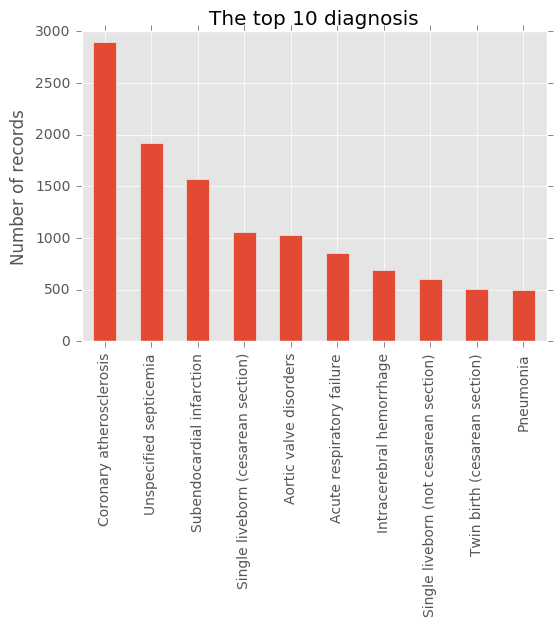

In [16]:
# simplify and rename the diagnoses names based on the printted results
top_diagonsis.index = ['Coronary atherosclerosis', 'Unspecified septicemia', 'Subendocardial infarction', \
                       'Single liveborn (cesarean section)', 'Aortic valve disorders', 'Acute respiratory failure',\
                      'Intracerebral hemorrhage', 'Single liveborn (not cesarean section)', 'Twin birth (cesarean section)',\
                      'Pneumonia']
# plot the top 10 most frequent diagnosis
top_diagonsis.plot(kind = 'bar')
plt.ylabel('Number of records')
plt.title('The top 10 diagnosis')

#### 5.2 Number of stroke cases for different categories of SEQ_NUM

/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


      1    2    3    4   5   6   7   8
1  2284  559  198  121  90  84  46  31


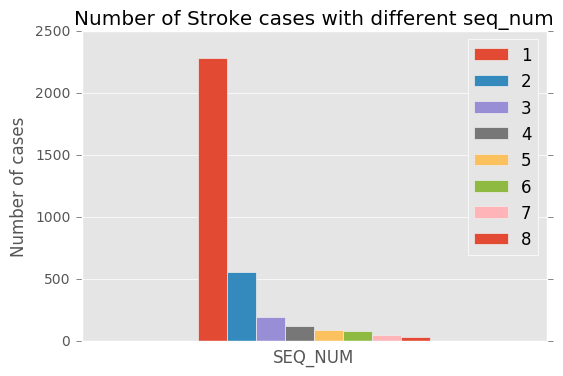

In [17]:
# set up a pandas dataframe 
dict_count = {}
df_temp = pd.DataFrame()
# examine SEQ_NUM column with values ranged from 1 to 8
for i in range(1, 9):
    df_temp = codes_data_copy[codes_data_copy['SEQ_NUM'] == i]
    # label stroke as 1 and non-stroke as 0
    df_temp['counts'] = df_temp.apply(lambda row:is_stroke(row, is_count = True), axis = 1)
    # count number of stroke cases
    dict_count[i] = df_temp['counts'].sum()
df_counts = pd.DataFrame(dict_count, index = [1])
# print out the results
print df_counts
# plot the results
df_counts.plot(kind = 'bar')    
plt.xticks([''])
plt.xlabel('SEQ_NUM')
plt.ylabel('Number of cases')
plt.title('Number of Stroke cases with different seq_num')

#### 5.3 Identify number of records in stroke and non-stroke group
Then, let's find out how many records in different categories of diseases.

In [18]:
# group the data by STROKE_LABEL and count the size in each group
primary_diseases = d_notes_codes_data.groupby(['STROKE_LABEL']).size()
primary_diseases.sort_values(ascending = False)

STROKE_LABEL
Non-Stroke    42174
Stroke         1904
dtype: int64

In [19]:
# percentage of stroke records
print 'The percentage of stroke records is %.2f' %(float(1904)*100/(1904+42174))

The percentage of stroke records is 4.32


#### 5.4 Random sampling non-stroke data

In [20]:
# drop unused columns
d_notes_codes_data.drop(['SUBJECT_ID', 'HADM_ID', 'TEXT'], axis = 1, inplace = True)
# sampling out stroke and non-stroke data and assign new user IDs
stroke = d_notes_codes_data[d_notes_codes_data['STROKE_LABEL'] == 'Stroke']
non_stroke = d_notes_codes_data[d_notes_codes_data['STROKE_LABEL'] == 'Non-Stroke']
non_stroke = non_stroke.sample(2000, random_state = 42)
d_notes_codes_data = pd.concat([stroke, non_stroke])
d_notes_codes_data['ID'] = range(1, d_notes_codes_data.shape[0] + 1)
# random shuffle data
d_notes_codes_data = d_notes_codes_data.sample(frac=1).reset_index(drop=True)
# examine the sampled data
d_notes_codes_data.head()

,CATEGORY,ICD9_CODE,LONG_TITLE,PAST MEDICAL HISTORY,SOCIAL HISTORY,FAMILY HISTORY,HISTORY INFO,STROKE_LABEL,ID
0,Discharge summary,03842,Septicemia due to escherichia coli [E. coli],1 Erosive RA previously on plaquenil off ...,Originally from Currently in nursing home ...,none relavent to this presentation,1 Erosive RA previously on plaquenil off ...,Non-Stroke,1971
1,Discharge summary,43411,Cerebral embolism with cerebral infarction,Hypertension Atrial fibrillation s p PPM not ...,"She lives at home with her daughter, and does...",There is no family history of strokes,Hypertension Atrial fibrillation s p PPM not ...,Stroke,1664
2,Discharge summary,431,Intracerebral hemorrhage,MI x3 most recent s p angioplasty HTN...,Lives at home with wife that comes to h...,Non contributory,MI x3 most recent s p angioplasty HTN...,Stroke,781
3,Discharge summary,43411,Cerebral embolism with cerebral infarction,1 HTN 2 s p hip replacement in 3 s p spi...,Lives alone independent in all IADLs includ...,Sister died of MI,1 HTN 2 s p hip replacement in 3 s p spi...,Stroke,1731
4,Discharge summary,43491,"Cerebral artery occlusion, unspecified with ce...",DM2 HTN HLD Cellulitis R LE Uterine fibroids ...,"Lives in with husband smoking, alcohol, ...",Father d of lung cancer at age 64 mother di...,DM2 HTN HLD Cellulitis R LE Uterine fibroids ...,Stroke,1424


## Natural language processing
This section applys natural language processing technique to further process and analyze the patients' medical, social and family history information. First, the medication abbreviations are replaced with the full terms.

### 1. Replace medical abbreviations

In [21]:
import nltk
from nltk.corpus import wordnet as wn
from sklearn.externals import joblib
import re

def nlp_text_clean(row):
    '''
    this function has 2 functions: 1. replace medical abbreviations with full terms, 
    2. check misspell - Synset: a set of synonyms that share a common meaning
    '''
    total_words_count = 0
    med_abbr_count = 0
    mis_spell_count = 0
    # 1. replace abbreviations
    med_dict = joblib.load('med_dict.plk')
    string = row['HISTORY INFO']
    string = re.sub('\[.*?\]', ' ', string)
    string = re.sub('[^a-zA-Z0-9]+', ' ', string)
    string = re.sub('[ ]+', ' ', string) # remove multiple white space
    re_string = ''
    # work on this line
    for s in string.split():
        if s in med_dict:
            s = med_dict[s]
            med_abbr_count += 1
        total_words_count += 1
        re_string += s
        re_string += ' '
    for s in re_string.strip().split():
        try:
            if not wn.synsets(s) and s != ' ':
                mis_spell_count += 1 # count potential mis spell words
        except UnicodeDecodeError:
            continue
    single_letter = re.compile(r'\W*\b\w{1,1}\b')
    re_string = single_letter.sub('', re_string)
    # remove terms in () that from medical terms
    re_string = re.sub('\(.*?\)', ' ', re_string)
    re_string = re.sub('[()-:]+', ' ', re_string)
    re_string = re.sub('[ ]+', ' ', re_string)
    re_string = re_string.strip()
    return (re_string.lower(), total_words_count, med_abbr_count, mis_spell_count)

In [22]:
# natural language processing to replace medical abbreviations and remove special characters
d_notes_codes_data['HISTORY INFO NLP'] = d_notes_codes_data.apply(lambda row : nlp_text_clean(row), axis = 1)
d_notes_codes_data['HISTORY INFO NLP'].head(1).values

array([ ('erosive refractory anemia previously on plaquenil off years also chronic nonsteroidal antiinflammatory drug use no dmards or biologics in the past per rheum note on prednisone mg daily likely started aortic insufficiency on echo in hypertension anemia previous labs anemia of chronic inflammation also b deficiency chronic renal insufficiency baseline creatinine around hyperlipidemia vitiligo secondary to plaquenil use history of esophageal tear positive packs per day in past per pneumocystis carinii pneumonia no inhaled treatment originally from currently in nursing home facility senior healthcare of has one sister who lives out of state no children tobacco no smoking history per medical records no etoh or illicit drug use none relavent to this presentation', 128, 9, 25)], dtype=object)

In [23]:
# get cleaned history info data
print d_notes_codes_data['HISTORY INFO'].head(1).values
d_notes_codes_data['HISTORY INFO'] = d_notes_codes_data['HISTORY INFO NLP'].apply(lambda x : x[0])
print d_notes_codes_data['HISTORY INFO'].head(1).values 

[ ' 1  Erosive RA   previously on plaquenil  off  10 years  Also h o chronic NSAID use  No DMARDs or biologics in the past per rheum note 04    On prednisone 10mg daily  likely started 04   2  Aortic insufficiency  1  on echo in   3  HTN 4  Anemia   previous labs c w anemia of chronic inflammation, also h o B12 deficiency 5  CRI  baseline Cr around 1 4 1 5 6  Hyperlipidemia 7  Vitiligo  secondary to plaquenil use 8  Hx of esophageal tear   9  Positive PPD in past, per PCP no   o INH treatment   Originally from    Currently in nursing home facility   Senior Healthcare of    Has one sister, who lives out of state   No children   Tobacco: no smoking history per medical records  No EtOH or illicit drug use   none relavent to this presentation ']
[ 'erosive refractory anemia previously on plaquenil off years also chronic nonsteroidal antiinflammatory drug use no dmards or biologics in the past per rheum note on prednisone mg daily likely started aortic insufficiency on echo in hypertension 

In [24]:
# get total number of words in data
d_notes_codes_data['TOTAL_COUNT'] = d_notes_codes_data['HISTORY INFO NLP'].apply(lambda x : x[1])
total_count = d_notes_codes_data['TOTAL_COUNT'].sum()
print 'Number of words: %d' %total_count

Number of words: 288637


In [25]:
# get total number of medical abbreviations
d_notes_codes_data['ABBR_COUNT'] = d_notes_codes_data['HISTORY INFO NLP'].apply(lambda x : x[2])
med_abbr_count = d_notes_codes_data['ABBR_COUNT'].sum()
print 'Number of medical abbreviations: %d' %med_abbr_count
print 'Percentage of medical abbreviations: %.2f' %(float(med_abbr_count)*100/total_count)

Number of medical abbreviations: 15128
Percentage of medical abbreviations: 5.24


### 2. Examine the potential mis-spelling words

In [26]:
# get the number of potential mis spelled words
d_notes_codes_data['MIS_SPELL_COUNT'] = d_notes_codes_data['HISTORY INFO NLP'].apply(lambda x : x[3])
mis_spell_count = d_notes_codes_data['MIS_SPELL_COUNT'].sum()
print 'Percentage of potential mis-spell: %.2f' %(float(mis_spell_count)*100/total_count)

Percentage of potential mis-spell: 17.92


### 3. Remove missing values after processing

In [27]:
# count rows with only none and unknown values
d_notes_codes_data_rm_nan = d_notes_codes_data[pd.notnull(d_notes_codes_data['HISTORY INFO'])]
mis_count = d_notes_codes_data.shape[0] - d_notes_codes_data_rm_nan.shape[0]
mis_count += d_notes_codes_data[d_notes_codes_data['HISTORY INFO'] == ''].shape[0]
null_count = 0
none_list = ['none', 'none none', 'none none none', 'unknown', 'unknown unknown',
             'unknown unknown unknown', 'none unknown unknown', 'denies', 'noncontributory',
            'unknown unknown nc', 'as above', 'non contributory']
for s in none_list:
    null_count += d_notes_codes_data_rm_nan[d_notes_codes_data_rm_nan['HISTORY INFO'] == s].shape[0]
clean_data = d_notes_codes_data_rm_nan[~d_notes_codes_data_rm_nan['HISTORY INFO'].isin (none_list)]
clean_data = clean_data[clean_data['HISTORY INFO'] != '']
print 'Number of none or unknown value: %d' %null_count
# get the total missing values for stroke data
# number of rows without values
print 'Number of total missing value: %d' %(null_count + mis_count)
print 'Stroke cases: %d' %clean_data[clean_data['STROKE_LABEL'] == 'Stroke'].shape[0]
print 'Non-Stroke cases: %d' %clean_data[clean_data['STROKE_LABEL'] == 'Non-Stroke'].shape[0]

Number of none or unknown value: 26
Number of total missing value: 29
Stroke cases: 1892
Non-Stroke cases: 1983


### 4. Save test cases and model train-validation cases for the web app

In [28]:
# separate out test cases and save
test_cases = clean_data.iloc[:100, :]
test_cases.to_csv('stroke_his_info_db.csv', index = False)
# separate out train-val data and save
train_val_data = clean_data.iloc[100:, :]
train_val_data.to_csv('stroke_his_info.csv', index = False)

### 5. Split data and analyze the training data with NLP

In [29]:
# split train and test data
from sklearn.model_selection import train_test_split

# combine history information
X = train_val_data['HISTORY INFO'].values

# get a list of y values
labels = train_val_data['STROKE_LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20,\
                                                    random_state = 42)
# examine the data shape in train and test data
stroke_values = []
non_stroke_values = []
stroke_labels = []
non_stroke_labels = []
# transform labels to binary values
for i in range(y_train.shape[0]):
    if y_train[i] == 'Stroke':
        stroke_values.append(X_train[i])
        stroke_labels.append('Stroke')
    else:
        non_stroke_values.append(X_train[i])
        non_stroke_labels.append('Non-stroke')
print len(stroke_values), len(non_stroke_values)

1473 1547


### 6. Similarity of text notes and top features with automatically defined vocabulary
The next interesting question is how similar are the notes between stroke and non-stroke records. To do that, the history information is first tokenized with stemmer and converted into occurance of words with sklearn CountVectorizer or term frequency–inverse document frequency with TfidfVectorizer. Then, the cosine similarity between records is computed and the heatmap is created with the similarity matrix.

In [30]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def tokenizer(text):
    stemmed = []
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)
    text = re.sub('[ ]+', ' ', text)
    text.strip()
    words = text.split()
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

#### 6.1 Cosine similarity

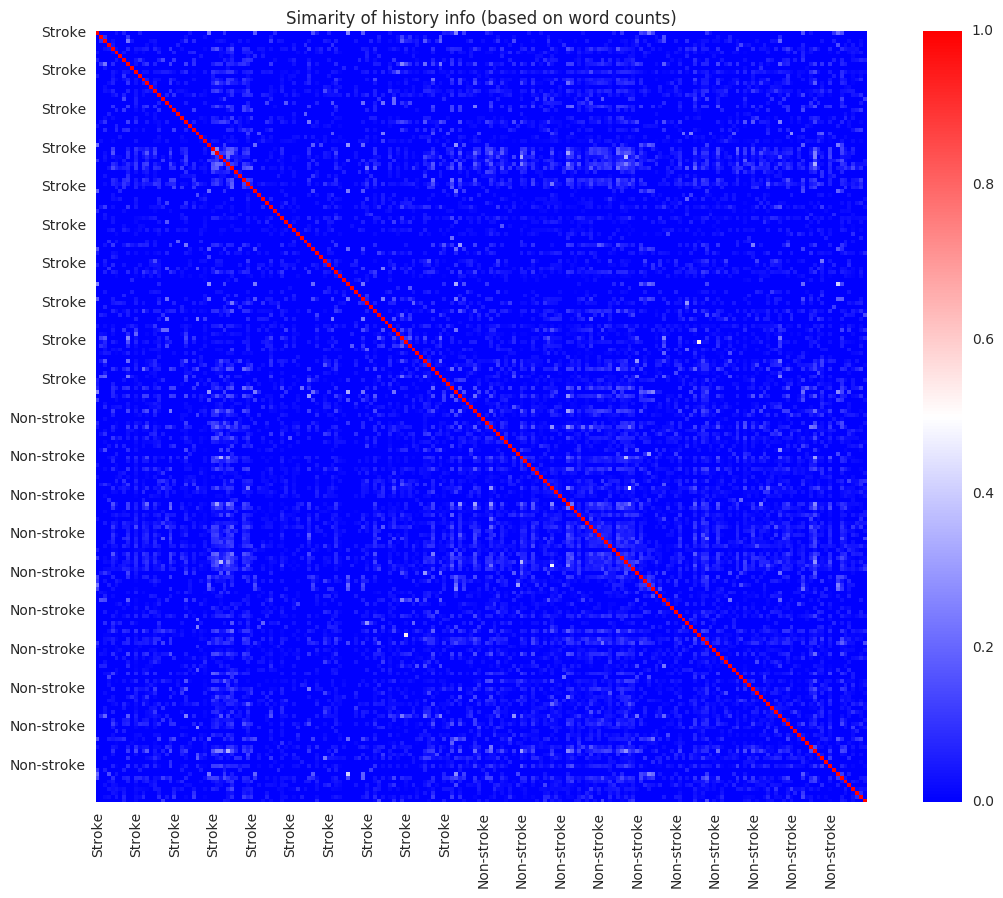

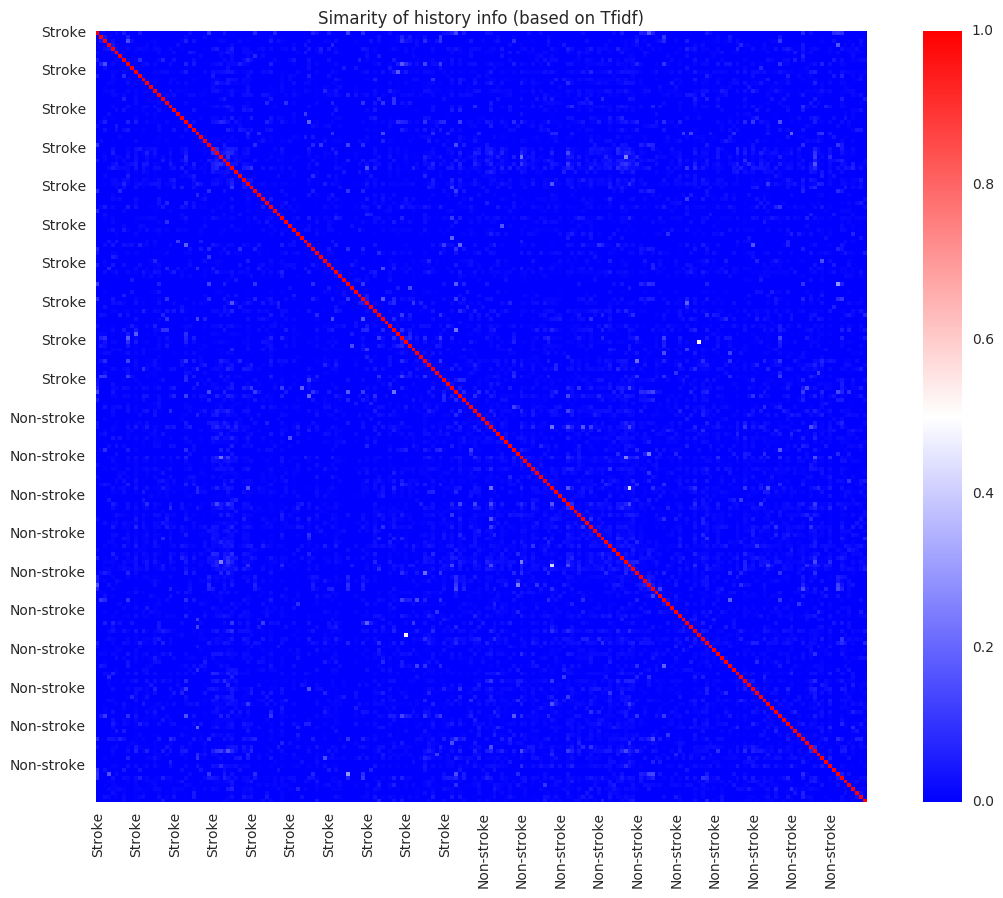

In [31]:
# import sklearn packages, visulization seaborn package and numpy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def heatmap(text, xticks, vec, title, is_voc = False, is_count = False):
    '''
    define a function to plot heatmap
    '''
    keptticks = xticks[::int(len(xticks)/20)]
    xticks = ['' for y in xticks]
    xticks[::int(len(xticks)/20)] = keptticks
    # transform text data
    X = vec.fit_transform(text)
    # compute cosine similarity
    cos_similarity = cosine_similarity(X)
    f, ax = plt.subplots(figsize=(12, 9))
    # generate heatmap
    sns.heatmap(cos_similarity, square=True, cmap='bwr', yticklabels = xticks, xticklabels = xticks)
    f.tight_layout()
    plt.title(title)

# combine infos, use 200 samples to compare
text = stroke_values[:100] + non_stroke_values[:100]
xticks = stroke_labels[:100] + non_stroke_labels[:100]

# create cosine similarity heatmap based on count vectorizer
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
title = 'Simarity of history info (based on word counts)'
heatmap(text, xticks, count_vec, title, is_count = True)
# create cosine similarity heatmap based on tfidf vectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
title = 'Simarity of history info (based on Tfidf)'
heatmap(text, xticks, tfidf_vec, title)

The word occurance heatmap shows higher similarity between different records as compared to the term frequency–inverse document frequency heatmap. The high similarity for word occurance may suggest a high noise. 

#### 6.2 Top ten words in stroke data

In [32]:
# converted notes into occurance of words with sklearn CountVectorizer
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_stroke_count = count_vec.fit_transform(stroke_values)
print ('The number of features with count vectorizer transformation: %d'%X_stroke_count.shape[1])
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_stroke_tfidf = tfidf_vec.fit_transform(stroke_values)
print ('The number of features with tfidf vectorizer transformation: %d'%X_stroke_tfidf.shape[1])

The number of features with count vectorizer transformation: 30014
The number of features with tfidf vectorizer transformation: 30014


In [33]:
import numpy as np
# find top 10 terms
top_n = 10
features_count = count_vec.get_feature_names()
counts = X_stroke_count.astype(float)
# sort the index by the word occurance in descending order
counts_ind = np.argsort(counts.toarray().sum(axis = 0))[::-1]
# get top 10 frequent words
top_features_count_stroke = [(features_count[i], counts.toarray().sum(axis = 0)[i]) for i in counts_ind[:top_n]]
# get 10 least freqent words
bottom_features_count_stroke = [(features_count[i], counts.toarray().sum(axis = 0)[i]) for i in counts_ind[-top_n:]]
# sort the index by the tfidf in descending order
indices = np.argsort(tfidf_vec.idf_)[::-1]
# get top 10 words with highest tfidf
features_tfidf = tfidf_vec.get_feature_names()
top_features_tfidf_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[:top_n]]
# get top 10 words with lowest tfidf
bottom_features_tfidf_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[-top_n:]]
top_features_name_tfidf_stroke = [str(features_tfidf[i]) for i in indices[:top_n]]

print 'The 10 features with most frequency in stroke records:', top_features_count_stroke
print 'The 10 features with least frequency in stroke records:', bottom_features_count_stroke
print "\n"
print 'The 10 features with highest tfidf in stroke records:', top_features_tfidf_stroke
print 'The 10 features with lowest tfidf in stroke records:',bottom_features_tfidf_stroke

The 10 features with most frequency in stroke records: [(u'coronari arteri', 436.0), (u'diabet mellitus', 347.0), (u'arteri diseas', 322.0), (u'year ago', 298.0), (u'myocardi infarct', 241.0), (u'atrial fibril', 202.0), (u'mellitus dermatomyos', 199.0), (u'live wife', 192.0), (u'famili histori', 191.0), (u'drug use', 172.0)]
The 10 features with least frequency in stroke records: [(u'occasion like', 1.0), (u'occasion live', 1.0), (u'occasion marijuana', 1.0), (u'occasion medic', 1.0), (u'occasion migrain', 1.0), (u'occasion nerv', 1.0), (u'occasion night', 1.0), (u'occasion numb', 1.0), (u'occasion past', 1.0), (u'aa sinc', 1.0)]


The 10 features with highest tfidf in stroke records: [(u'zyrtec levoxyl', 7.6025878921893364), (u'fraction work', 7.6025878921893364), (u'fractur manubrium', 7.6025878921893364), (u'fractur mitral', 7.6025878921893364), (u'fractur motor', 7.6025878921893364), (u'fractur patellar', 7.6025878921893364), (u'fractur patient', 7.6025878921893364), (u'fractur per

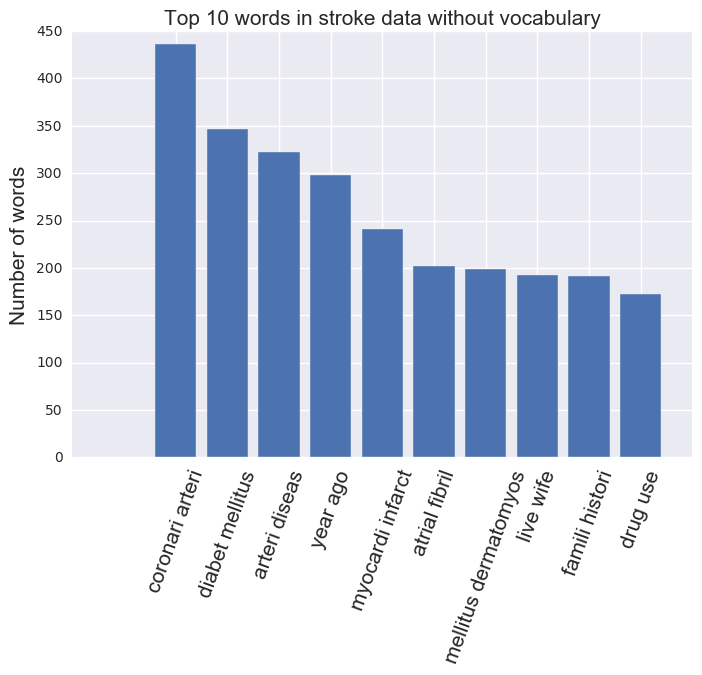

In [34]:
def plot_words(top_features, title, ylabel):
    '''
    This method generates plots for top features
    '''
    x_trick = range(len(top_features))
    plt.bar(x_trick, [t[1] for t in top_features], align='center')
    labels = [t[0] for t in top_features]
    plt.title(title, fontsize = 15)
    plt.xticks(x_trick, labels,  fontsize = 15, rotation=70)
    plt.ylabel(ylabel, fontsize = 15)
    plt.show()
title = 'Top 10 words in stroke data without vocabulary'
ylabel = 'Number of words'
top_features = top_features_count_stroke
plot_words(top_features, title, ylabel)

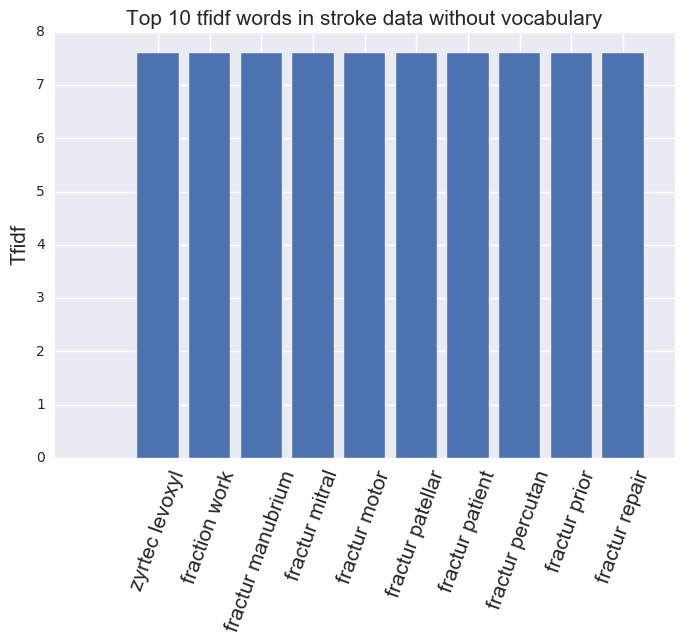

In [35]:
title = 'Top 10 tfidf words in stroke data without vocabulary'
ylabel = 'Tfidf'
top_features = top_features_tfidf_stroke
plot_words(top_features, title, ylabel)

#### 6.3 Top ten words for non-stroke data

In [36]:
# converted notes into occurance of words with sklearn CountVectorizer
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_non_stroke_count = count_vec.fit_transform(non_stroke_values)
print ('The number of features with count vectorizer transformation: %d'%X_non_stroke_count.shape[1])
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_non_stroke_tfidf = tfidf_vec.fit_transform(non_stroke_values)
print ('The number of features with tfidf vectorizer transformation: %d'%X_non_stroke_tfidf.shape[1])

The number of features with count vectorizer transformation: 46444
The number of features with tfidf vectorizer transformation: 46444


In [37]:
features_count = count_vec.get_feature_names()
# sort index by word frequency 
counts = X_non_stroke_count.astype(float)
counts_ind = np.argsort(counts.toarray().sum(axis = 0))[::-1]
# get 10 most frequent features
top_features_count_non_stroke = [(features_count[i], X_non_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[:top_n]]
# get 10 least frequent features
bottom_features_count_non_stroke = [(features_count[i], X_non_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[-top_n:]]
# sort index by word tfidf
indices = np.argsort(tfidf_vec.idf_)[::-1]
# get 10 highest tfidf
features_tfidf = tfidf_vec.get_feature_names()
top_features_tfidf_non_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[:top_n]]
# get 10 lowest tfidf
bottom_features_tfidf_non_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[-top_n:]]
top_features_name_tfidf_non_stroke = [str(features_tfidf[i]) for i in indices[:top_n]]

print 'The 10 features with most frequency in non-stroke records:', top_features_count_non_stroke
print 'The 10 features with least frequency in non-stroke records:', bottom_features_count_non_stroke
print "\n"
print 'The 10 features with highest tfidf in non-stroke records:', top_features_tfidf_non_stroke
print 'The 10 features with lowest tfidf in non-stroke records:',bottom_features_tfidf_non_stroke

The 10 features with most frequency in non-stroke records: [(u'coronari arteri', 925), (u'arteri diseas', 611), (u'diabet mellitus', 510), (u'status post', 455), (u'myocardi infarct', 415), (u'year ago', 397), (u'heart failur', 275), (u'famili histori', 249), (u'congest heart', 239), (u'eject fraction', 234)]
The 10 features with least frequency in non-stroke records: [(u'occassion father', 1), (u'occasion unknown', 1), (u'occassion famili', 1), (u'occassion excess', 1), (u'occassion drink', 1), (u'occasion word', 1), (u'occasion wine', 1), (u'occasion walk', 1), (u'occasion vodka', 1), (u'aa maintain', 1)]


The 10 features with highest tfidf in non-stroke records: [(u'issu retrolisthesi', 7.6515718735897273), (u'fractur requir', 7.6515718735897273), (u'friday congest', 7.6515718735897273), (u'friabl stent', 7.6515718735897273), (u'friabl nodular', 7.6515718735897273), (u'friabl mass', 7.6515718735897273), (u'friabil lower', 7.6515718735897273), (u'fri x', 7.6515718735897273), (u'fri 

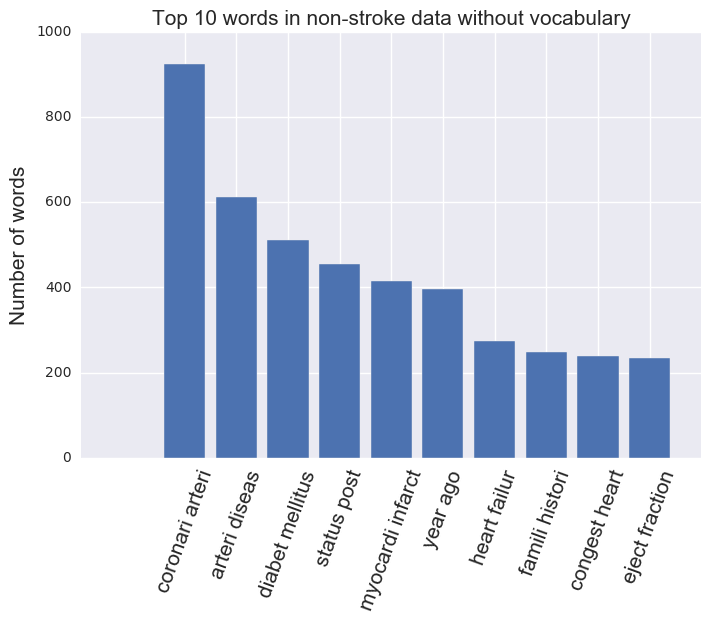

In [38]:
title = 'Top 10 words in non-stroke data without vocabulary'
ylabel = 'Number of words'
top_features = top_features_count_non_stroke
plot_words(top_features, title, ylabel)

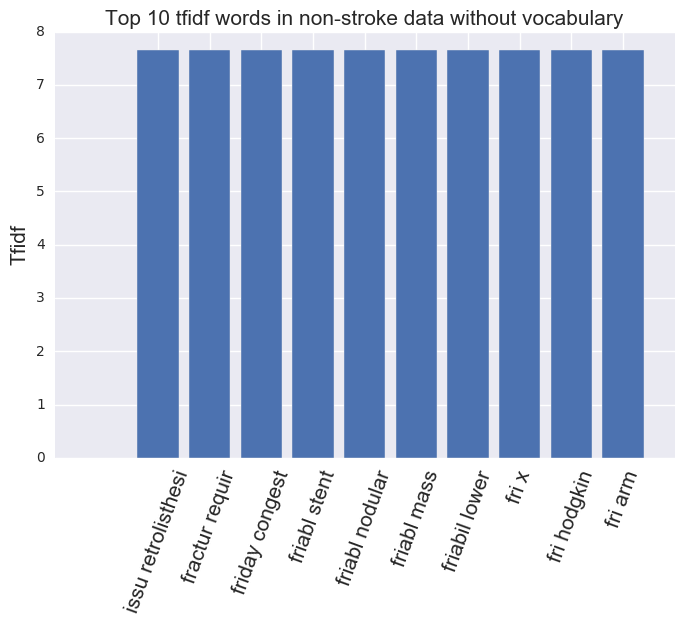

In [39]:
title = 'Top 10 tfidf words in non-stroke data without vocabulary'
ylabel = 'Tfidf'
top_features = top_features_tfidf_non_stroke
plot_words(top_features, title, ylabel)

The words with highest frequency in both stroke and non-stroke records are very similar, but the words recognized by tfidf are very different in stroke and non-stroke records.

### 7. Similarity of history information and top features with medical terms defined vocabulary

In [40]:
# use the diagnosis names to generate a vocarbuary with medical terms
path = 'D_ICD_DIAGNOSES.csv'

df = pd.read_csv(path)
values = df['LONG_TITLE'].values
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
medical_word_tfidf = tfidf_vec.fit_transform(values)
words = tfidf_vec.get_feature_names()
words_dict = {v:k for k, v in dict(enumerate(words)).items()}

#### 7.1 Examine the similarity of history information

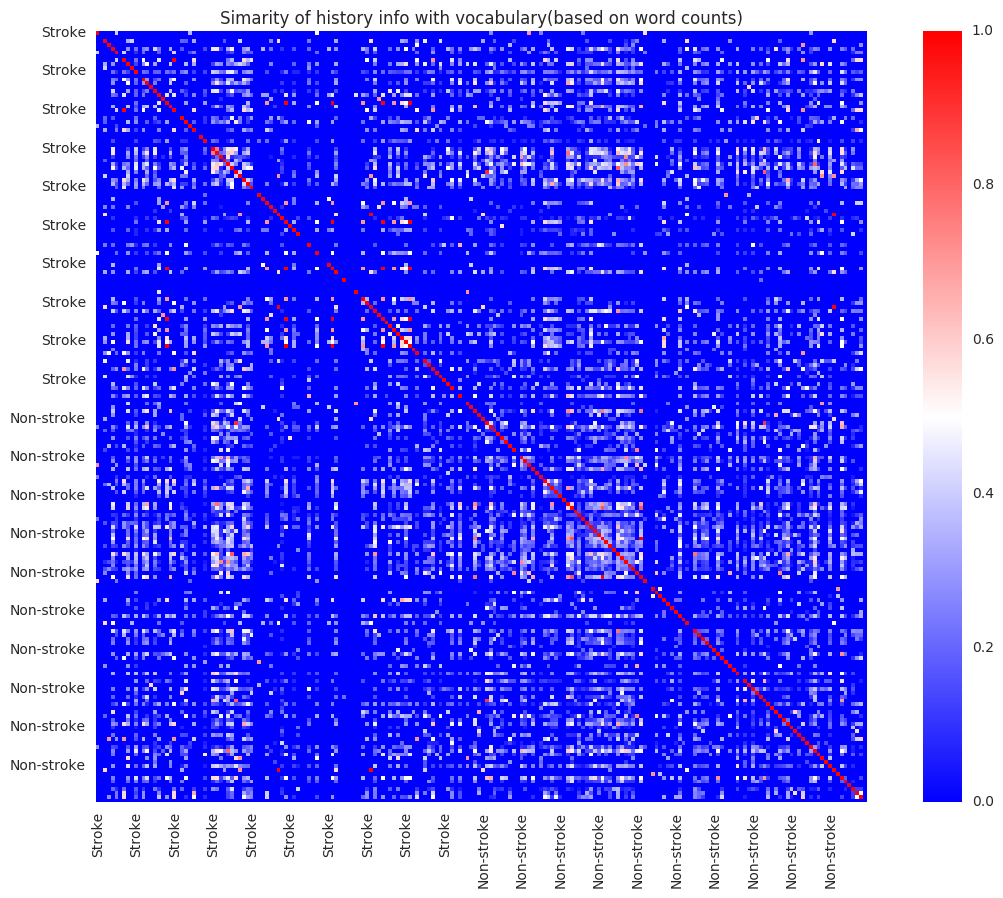

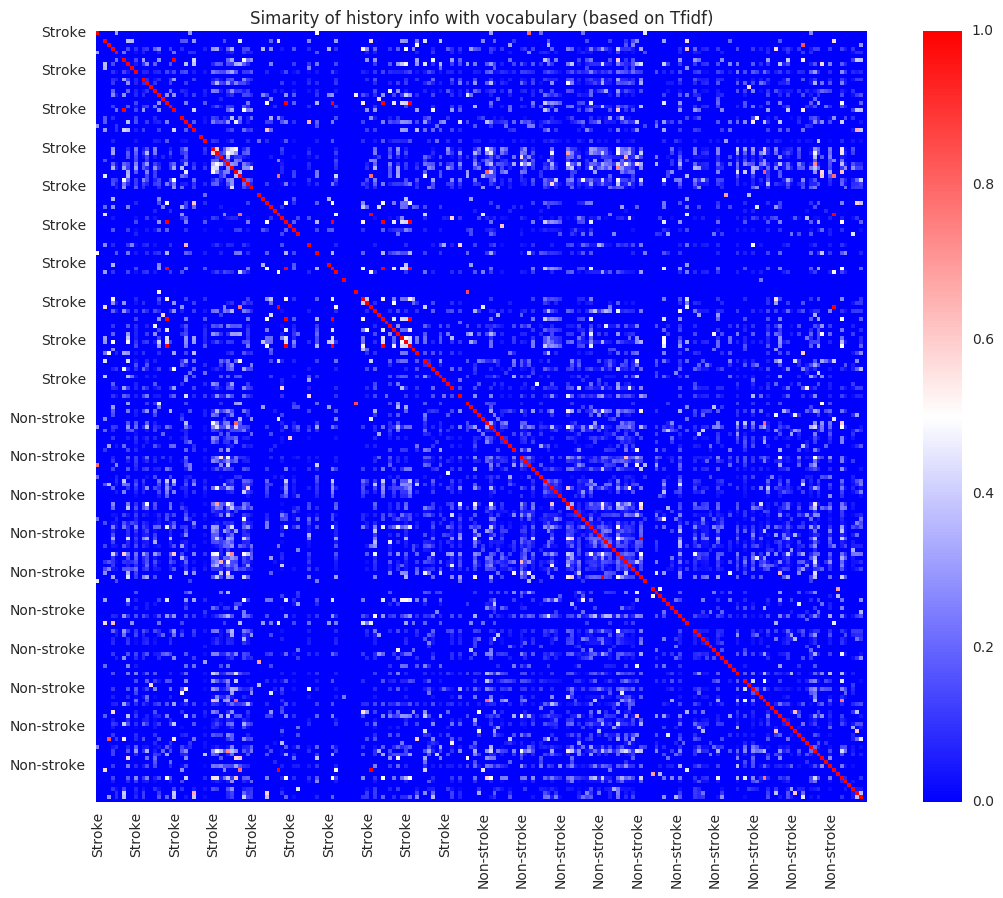

In [41]:
# create cosine similarity heatmap based on count vectorizer
text = stroke_values[:100] + non_stroke_values[:100]
xticks = stroke_labels[:100] + non_stroke_labels[:100]
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', vocabulary = words_dict, 
                            tokenizer = tokenizer)
title = 'Simarity of history info with vocabulary(based on word counts)'
heatmap(text, xticks, count_vec, title, is_count = True)
# create cosine similarity heatmap based on tfidf vectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', vocabulary = words_dict, 
                            tokenizer = tokenizer)
title = 'Simarity of history info with vocabulary (based on Tfidf)'
heatmap(text, xticks, tfidf_vec, title)

The history information is very similar based on the heatmap as generated with word frequency or tfidf

#### 7.2 Examine the top features in stroke records

In [42]:
# converted notes into occurance of words with sklearn CountVectorizer
count_vec = CountVectorizer(ngram_range = (2,2), vocabulary = words_dict, tokenizer = tokenizer)
X_stroke_count = count_vec.fit_transform(stroke_values)
print ('The number of features with count vectorizer transformation: %d'%X_stroke_count.shape[1])
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), vocabulary = words_dict, tokenizer = tokenizer)
X_stroke_tfidf = tfidf_vec.fit_transform(stroke_values)
print ('The number of features with tfidf vectorizer transformation: %d'%X_stroke_tfidf.shape[1])

The number of features with count vectorizer transformation: 16592
The number of features with tfidf vectorizer transformation: 16592


In [43]:
#vectorizer = TfidfVectorizer(stop_words = "english", vocabulary = {"food": 0, "some":1})
import numpy as np
top_n = 10
features_count = count_vec.get_feature_names()
counts = X_stroke_count.astype(float)
counts_ind = np.argsort(counts.toarray().sum(axis = 0))[::-1]
top_features_count_stroke = [(features_count[i], X_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[:top_n]]
bottom_features_count_stroke = [(features_count[i], X_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[-top_n:]]


indices = np.argsort(tfidf_vec.idf_)[::-1]
features_tfidf = tfidf_vec.get_feature_names()
top_features_tfidf_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[:top_n]]
bottom_features_tfidf_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[-top_n:]]
top_features_name_tfidf_stroke = [str(features_tfidf[i]) for i in indices[:top_n]]

print 'The 10 features with most frequency in stroke records with vocabuary:', top_features_count_stroke
print 'The 10 features with least frequency in stroke records with vocabuary:', bottom_features_count_stroke
print "\n"
print 'The 10 features with highest tfidf in stroke records with vocabuary:', top_features_tfidf_stroke
print 'The 10 features with lowest tfidf in stroke records with vocabuary:',bottom_features_tfidf_stroke

The 10 features with most frequency in stroke records with vocabuary: [(u'coronari arteri', 436), (u'diabet mellitus', 347), (u'myocardi infarct', 241), (u'atrial fibril', 202), (u'famili histori', 189), (u'live alon', 145), (u'status post', 138), (u'benign prostat', 134), (u'heart failur', 125), (u'congest heart', 111)]
The 10 features with least frequency in stroke records with vocabuary: [(u'pancrea replac', 0), (u'pancrea multipl', 0), (u'pancrea islet', 0), (u'pancrea head', 0), (u'pancrea bodi', 0), (u'palsi unspecifi', 0), (u'palsi total', 0), (u'palsi partial', 0), (u'palsi conjug', 0), (u'0 25', 0)]


The 10 features with highest tfidf in stroke records with vocabuary: [(u'zygomycosi phycomycosi', 8.2957350727492809), (u'extractor deliveri', 8.2957350727492809), (u'extrem complic', 8.2957350727492809), (u'extrem cold', 8.2957350727492809), (u'extravas vesic', 8.2957350727492809), (u'extravas urin', 8.2957350727492809), (u'extravagin torsion', 8.2957350727492809), (u'extratesti

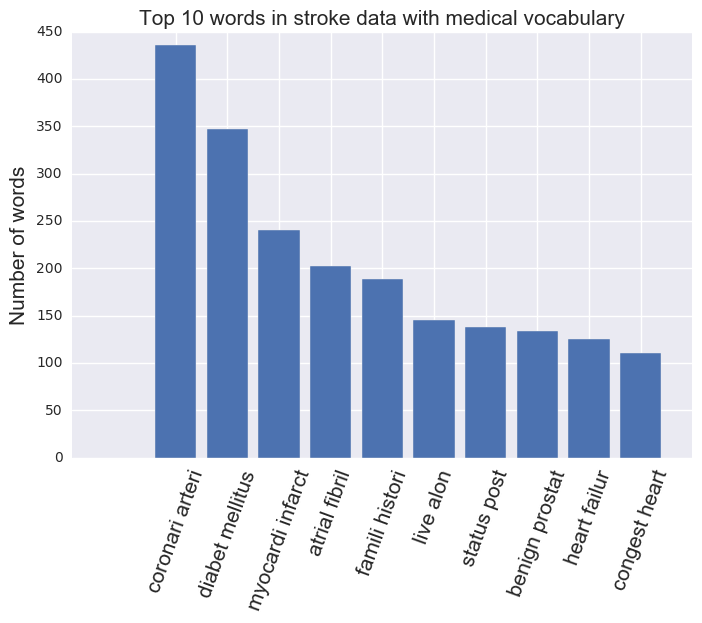

In [44]:
title = 'Top 10 words in stroke data with medical vocabulary'
ylabel = 'Number of words'
top_features = top_features_count_stroke
plot_words(top_features, title, ylabel)

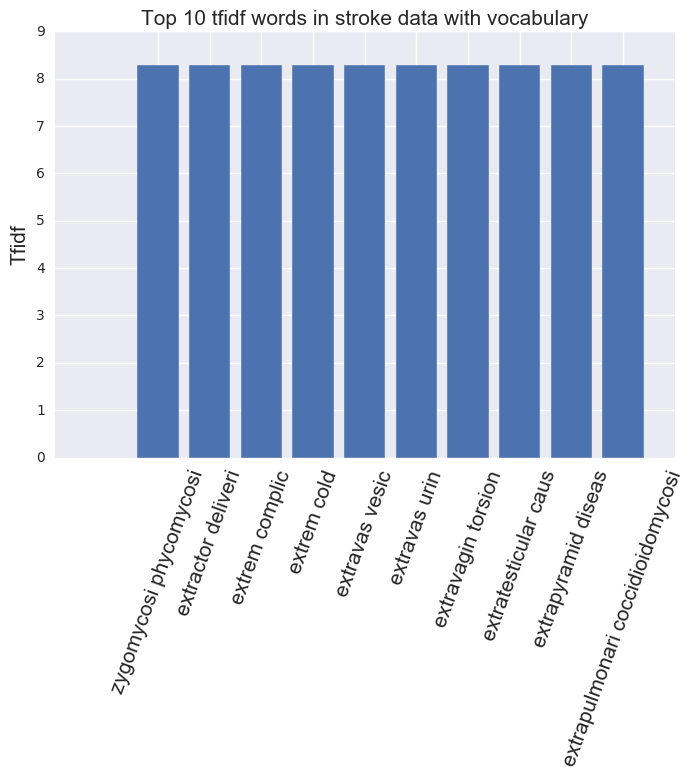

In [45]:
title = 'Top 10 tfidf words in stroke data with vocabulary'
ylabel = 'Tfidf'
top_features = top_features_tfidf_stroke
plot_words(top_features, title, ylabel)

#### 7.3 Examine the top features in non-stroke records

In [46]:
# converted notes into occurance of words with sklearn CountVectorizer
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', vocabulary = words_dict,
                            tokenizer = tokenizer)
X_non_stroke_count = count_vec.fit_transform(non_stroke_values)
print ('The number of features with count vectorizer transformation: %d'%X_non_stroke_count.shape[1])
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', vocabulary = words_dict, 
                            tokenizer = tokenizer)
X_non_stroke_tfidf = tfidf_vec.fit_transform(non_stroke_values)
print ('The number of features with tfidf vectorizer transformation: %d'%X_non_stroke_tfidf.shape[1])

The number of features with count vectorizer transformation: 16592
The number of features with tfidf vectorizer transformation: 16592


In [47]:
features_count = count_vec.get_feature_names()
counts = X_non_stroke_count.astype(float)
counts_ind = np.argsort(counts.toarray().sum(axis = 0))[::-1]
top_features_count_non_stroke = [(features_count[i], X_non_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[:top_n]]
bottom_features_count_non_stroke = [(features_count[i], X_non_stroke_count.toarray().sum(axis = 0)[i]) for i in counts_ind[-top_n:]]

indices = np.argsort(tfidf_vec.idf_)[::-1]
features_tfidf = tfidf_vec.get_feature_names()
top_features_tfidf_non_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[:top_n]]
bottom_features_tfidf_non_stroke = [(features_tfidf[i], tfidf_vec.idf_[i]) for i in indices[-top_n:]]
top_features_name_tfidf_non_stroke = [str(features_tfidf[i]) for i in indices[:top_n]]
print 'The 10 features with most frequency in non-stroke records with vocabuary:', top_features_count_non_stroke
print 'The 10 features with least frequency in non-stroke records with vocabuary:', bottom_features_count_non_stroke
print "\n"
print 'The 10 features with highest tfidf in non-stroke records with vocabuary:', top_features_tfidf_non_stroke
print 'The 10 features with lowest tfidf in non-stroke records with vocabuary:',bottom_features_tfidf_non_stroke

The 10 features with most frequency in non-stroke records with vocabuary: [(u'coronari arteri', 925), (u'diabet mellitus', 510), (u'status post', 455), (u'myocardi infarct', 415), (u'heart failur', 275), (u'famili histori', 249), (u'congest heart', 239), (u'arteri bypass', 232), (u'bypass graft', 229), (u'pulmonari diseas', 187)]
The 10 features with least frequency in non-stroke records with vocabuary: [(u'ostium secundum', 0), (u'ostium primum', 0), (u'osteoporosi unspecifi', 0), (u'osteopathi result', 0), (u'osteomyel upper', 0), (u'osteomyel specifi', 0), (u'osteomyel site', 0), (u'osteomyel shoulder', 0), (u'osteomyel pelvic', 0), (u'0 25', 0)]


The 10 features with highest tfidf in non-stroke records with vocabuary: [(u'zygomycosi phycomycosi', 8.3447190541496727), (u'face complic', 8.3447190541496727), (u'factiti disord', 8.3447190541496727), (u'facil elsewher', 8.3447190541496727), (u'facil 24', 8.3447190541496727), (u'facial syndrom', 8.3447190541496727), (u'facial bone', 8.3

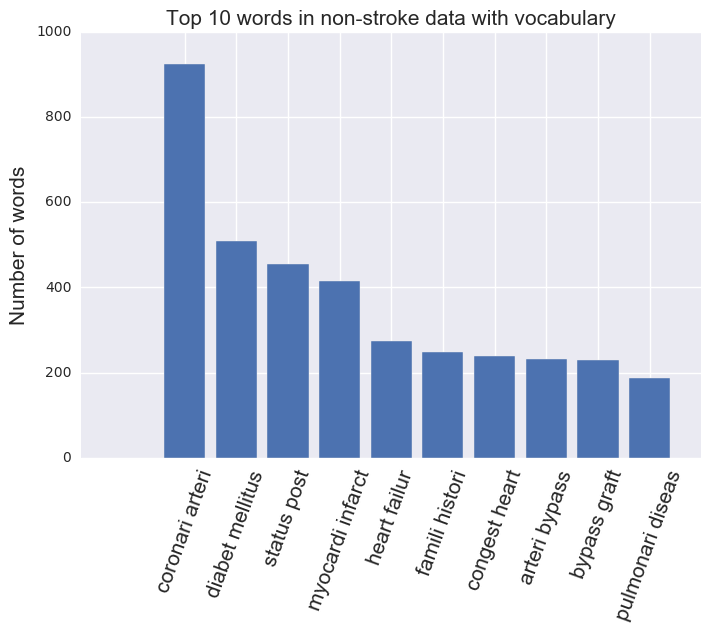

In [48]:
title = 'Top 10 words in non-stroke data with vocabulary'
ylabel = 'Number of words'
top_features = top_features_count_non_stroke
plot_words(top_features, title, ylabel)

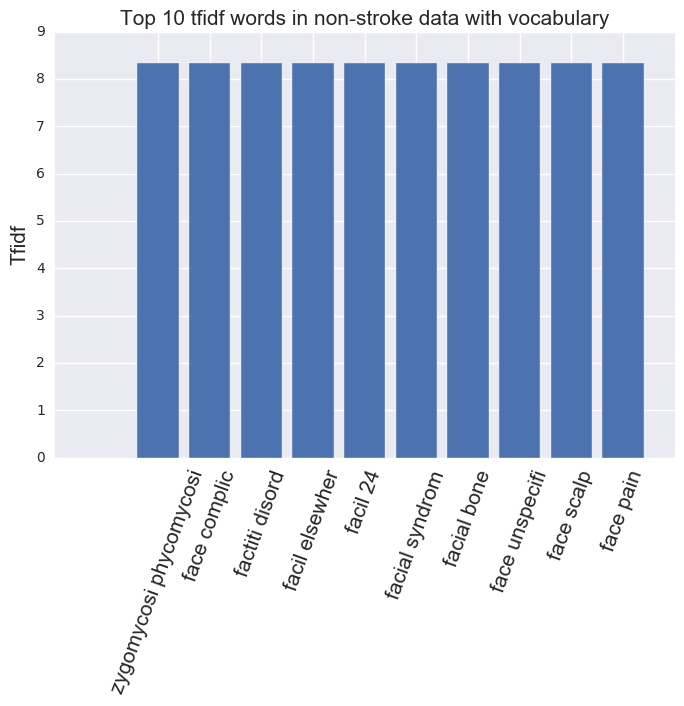

In [49]:
title = 'Top 10 tfidf words in non-stroke data with vocabulary'
ylabel = 'Tfidf'
top_features = top_features_tfidf_non_stroke
plot_words(top_features, title, ylabel)

Again, the words with highest frequency in both stroke and non-stroke records are very similar, but the words recognized by tfidf are very different in stroke and non-stroke records.

### PCA visualization

In [50]:
# convert text into word frequency
count_vec = CountVectorizer(ngram_range = (2,2), tokenizer = tokenizer)
X_count = count_vec.fit_transform(stroke_values + non_stroke_values)
counts = X_count.astype(float)
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), tokenizer = tokenizer)
X_tfidf = tfidf_vec.fit_transform(stroke_values + non_stroke_values)
print counts.shape
print X_tfidf.shape

(3020, 76481)
(3020, 76481)


In [51]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

def plot_2d(plot_columns, title, xlabel, ylabel):
    """
    this method generates 2D plot for dimensionality reduction
    """
    # Fit the model on the numeric columns from earlier.
    len_s = len(stroke_values)
    # Make a scatter plot, shaded according to cluster assignment.
    plt.figure(figsize = (8,8))
    plt.scatter(x=plot_columns[:len_s, 0], y=plot_columns[:len_s,1], c = ['red', 'green'], 
                cmap = cm.brg_r, label = 'Stroke')
    plt.scatter(x=plot_columns[len_s:,0], y=plot_columns[len_s:,1], c = 'green', 
                cmap = cm.brg_r, label = 'Non-Stroke')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = 4)

In [52]:
dataset_name = 'word ocurance'
X = counts.toarray()
# 1 for stroke and 0 for non-stroke
pca_2_count = PCA(2)
plot_columns_count = pca_2_count.fit_transform(X)
title = "Two PCA directions (%s)"%dataset_name
xlabel = "1st eigenvector"
ylabel = "2nd eigenvector"

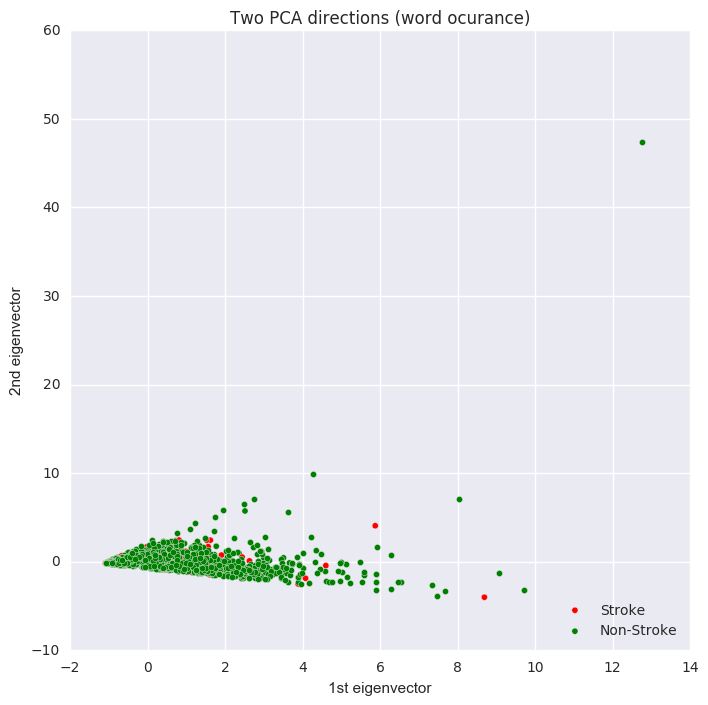

In [53]:
# visulize the data with word occurance
plot_2d(plot_columns_count, title, xlabel, ylabel) 

In [54]:
dataset_name = 'tfidf'
X = X_tfidf.toarray()
# 1 for stroke and 0 for non-stroke
pca_2_tfidf = PCA(2)
plot_columns_tfidf = pca_2_tfidf.fit_transform(X)
title = "Two PCA directions (%s)"%dataset_name
xlabel = "1st eigenvector"
ylabel = "2nd eigenvector"

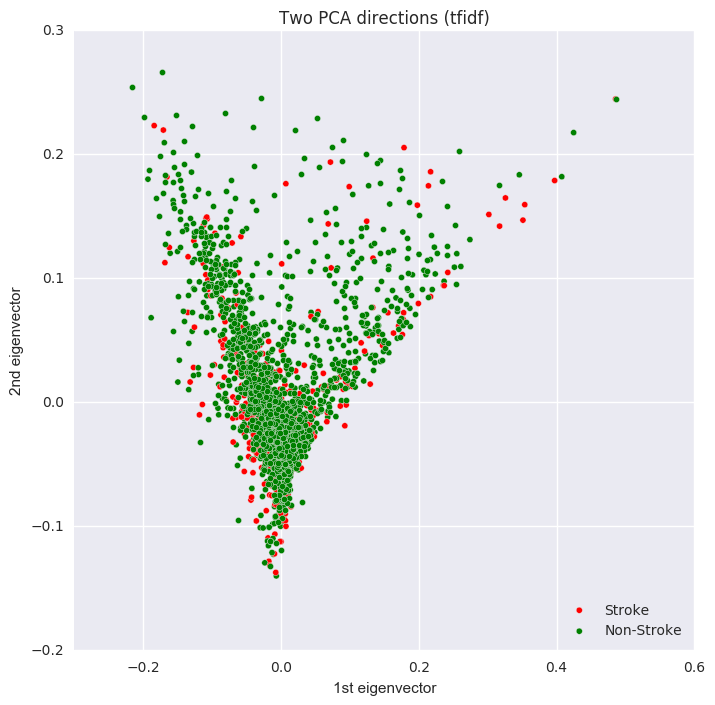

In [55]:
# visulize the data with word tfidf
plot_2d(plot_columns_tfidf, title, xlabel, ylabel)    

## Conclusion and Discussion

In this analysis, I analyzed the real deidentified medical records using natural language processing techniques. I performed the data cleaning and data exploration. I compared the similarity of medical, social and family history between patients with and without stroke. I explored the top features by computing word occurance and tfidf. In general, tfidf yields differential features between stroke and non-stroke groups as compared to the technique using word occurance. Finally, I used principle component analysis to visulize the stroke and no-stroke data ponits in 2D. The results showed that the stroke and non-stroke data are highly overlapped and not separated very well, which may reflect the reality of the difficulty for processing medical records. The cleaned data are applied to build machine models to predict risk of stroke in next notebook. 

## Reference

1. MIMIC-III, a freely accessible critical care database, Scientific Data 3, Article number: 160035 (2016)doi:10.1038/sdata.2016.35
2. Validity of Diagnostic Codes for Acute Stroke in Administrative Databases: A Systematic Review, PLoS One. 2015; 10(8): e0135834